<a href="https://colab.research.google.com/github/ByeongKeun/Industrial-AI/blob/master/%EA%B0%9C%EC%9D%B8%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/CM%EC%9D%B4%EB%AC%BC%EB%B6%88%EB%9F%89%20%EB%B6%84%EB%A5%98/2021_1110_ResNet_M12_Resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip( ),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/dataset_m12_resize'

In [21]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


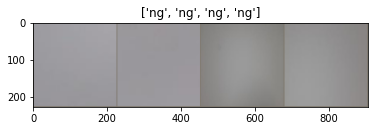

In [22]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict( ))
  best_acc = 0.0

  loss_history = {'train': [], 'test': []}
  acc_history = {'train': [], 'test': []}

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    for phase in ['train', 'test']:
      if phase == 'train':
        scheduler.step()
        model.train( )
      else:
        model.eval( )

      running_loss = 0.0
      running_correts = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad( )
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_correts += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_size[phase]
      epoch_acc = running_correts.double() / dataset_size[phase]

      loss_history[phase].append(epoch_loss)
      acc_history[phase].append(epoch_acc)
      
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
    
  time_elapsed = time.time() - since
  print('학습 완료 걸린시간: {:.0f}분 {:.0f}초'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best test Acc: {:.4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  return model, loss_history, acc_history

In [24]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far ==num_images:
          model.train(mode = was_training)
          return
      model.train(mode=was_training)

In [25]:
model_ft = models.resnet18(pretrained=True) #사전 학습된 ResNet18 가져오기
num_ftrs = model_ft.fc.in_features #모델에서 feature extraction 후, FC층에 입력되는 특징 수
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) #cpu나 GPU에 model_ft를 할당
criterion = nn.CrossEntropyLoss()

#모든 파라미터를 학습
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#매 7 에포크 마다 학습률 0.1배 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, loss_ft, acc_ft  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4016 Acc: 0.8574
test Loss: 0.6131 Acc: 0.7808

Epoch 1/24
----------
train Loss: 0.3428 Acc: 0.8685
test Loss: 0.5170 Acc: 0.7808

Epoch 2/24
----------
train Loss: 0.3463 Acc: 0.8621
test Loss: 0.8823 Acc: 0.7945

Epoch 3/24
----------
train Loss: 0.3390 Acc: 0.8669
test Loss: 0.3527 Acc: 0.9178

Epoch 4/24
----------
train Loss: 0.2746 Acc: 0.8859
test Loss: 0.7719 Acc: 0.7808

Epoch 5/24
----------
train Loss: 0.2958 Acc: 0.8906
test Loss: 0.4079 Acc: 0.8082

Epoch 6/24
----------
train Loss: 0.2447 Acc: 0.9065
test Loss: 0.3747 Acc: 0.9041

Epoch 7/24
----------
train Loss: 0.2228 Acc: 0.9033
test Loss: 0.4110 Acc: 0.8904

Epoch 8/24
----------
train Loss: 0.2098 Acc: 0.9160
test Loss: 0.4050 Acc: 0.9178

Epoch 9/24
----------
train Loss: 0.2016 Acc: 0.9049
test Loss: 0.4547 Acc: 0.9041

Epoch 10/24
----------
train Loss: 0.2210 Acc: 0.9065
test Loss: 0.4578 Acc: 0.9041

Epoch 11/24
----------
train Loss: 0.2268 Acc: 0.9097
test Loss: 0.4481 Acc: 0.8630

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


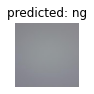

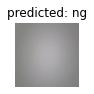

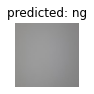

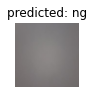

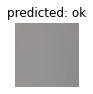

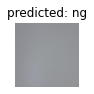

In [26]:
visualize_model(model_ft)

In [32]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False #사전 학습된 모델의 가중치를 상수로  고정. 학습시키지 않음

#새로 생성된 모듈의 파라미터는 기본적으로 requires_grad = True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

#마지막 층의 파라미터만 학습
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_conv, loss_conv, acc_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4178 Acc: 0.8716
test Loss: 0.5386 Acc: 0.7808

Epoch 1/24
----------
train Loss: 0.3796 Acc: 0.8621
test Loss: 0.3741 Acc: 0.8630

Epoch 2/24
----------
train Loss: 0.3669 Acc: 0.8590
test Loss: 0.2407 Acc: 0.9452

Epoch 3/24
----------
train Loss: 0.3525 Acc: 0.8637
test Loss: 0.1801 Acc: 0.9452

Epoch 4/24
----------
train Loss: 0.3330 Acc: 0.8685
test Loss: 0.2503 Acc: 0.9315

Epoch 5/24
----------
train Loss: 0.3117 Acc: 0.8780
test Loss: 0.2688 Acc: 0.8904

Epoch 6/24
----------
train Loss: 0.3252 Acc: 0.8859
test Loss: 0.2949 Acc: 0.9178

Epoch 7/24
----------
train Loss: 0.3289 Acc: 0.8859
test Loss: 0.2070 Acc: 0.9315

Epoch 8/24
----------
train Loss: 0.3528 Acc: 0.8653
test Loss: 0.4135 Acc: 0.9041

Epoch 9/24
----------
train Loss: 0.3538 Acc: 0.8732
test Loss: 0.2647 Acc: 0.9315

Epoch 10/24
----------
train Loss: 0.3640 Acc: 0.8716
test Loss: 0.4197 Acc: 0.8630

Epoch 11/24
----------
train Loss: 0.3818 Acc: 0.8685
test Loss: 0.7674 Acc: 0.7945

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


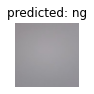

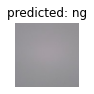

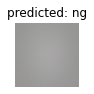

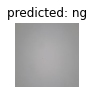

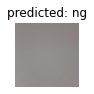

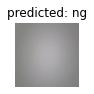

In [10]:
visualize_model(model_conv)

plt.ioff()
plt.show()

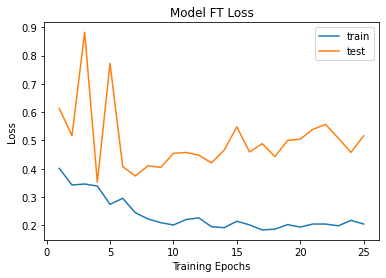

In [29]:
import matplotlib.pyplot as plt

num_epochs = 25

# plot loss progress
plt.title("Model FT Loss")
plt.plot(range(1,num_epochs+1),loss_ft["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_ft["test"],label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


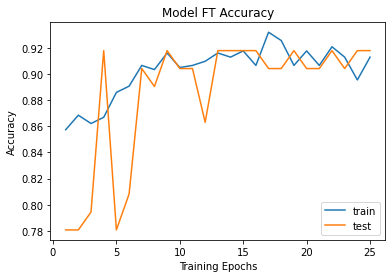

In [31]:

# plot accuracy progress
plt.title("Model FT Accuracy")
plt.plot(range(1,num_epochs+1),acc_ft["train"],label="train")
plt.plot(range(1,num_epochs+1),acc_ft["test"],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


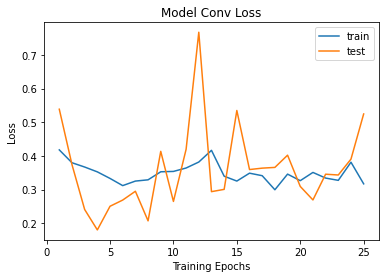

In [33]:

# plot loss progress
plt.title("Model Conv Loss")
plt.plot(range(1,num_epochs+1),loss_conv["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_conv["test"],label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


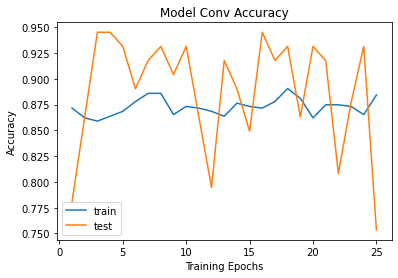

In [34]:

# plot accuracy progress
plt.title("Model Conv Accuracy")
plt.plot(range(1,num_epochs+1),acc_conv["train"],label="train")
plt.plot(range(1,num_epochs+1),acc_conv["test"],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()